Creo un dictionary in cui riporto tutti i modelli che andrò ad analizzare

In [5]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import nc_time_axis
import pytz
#from cdo import *
from funzioni import compute_dataset_weighted
from funzioni import compute_annual_mean_weighted
from funzioni import convert_dataset_celsius
from funzioni import compute_anomaly
from funzioni import create_djf_dataset
from funzioni import compute_mean_time_season
from funzioni import compute_mean_resample_mar

In [2]:
#cdo = Cdo()

In [6]:
# creo un dizionario in cui andrò a mettere tutti i modelli dentro
models = {}

In [7]:
#Costruisco il dizionario models con il nome del modello, il nomde del percorso di tutti i file *.nc di ogni modello e il nome di .nc, cioè il modello remapbil

#Percorso dei file
name_models = '/work/users/guest/sbeltrami/prova/name_ocean_model.txt'
path_models = '/work/users/guest/sbeltrami/prova/path_ocean_model.txt'
path_remap_models = '/work/users/guest/sbeltrami/prova/path_remap_ocean_model.txt'
# Apro i 3 file in modalità di lettura
with open(name_models, 'r') as file:
    # Leggo tutte le righe del file e salvo in una lista
    lines_name_models = file.readlines()
with open(path_models, 'r') as file:
    lines_path_models = file.readlines()
with open(path_remap_models, 'r') as file:
    lines_path_remap_models = file.readlines()


# Itero su tutte le righe dei 3 file e organizzo i dati nel dizionario
for line_name, line_path, line_path_remap in zip(lines_name_models, lines_path_models, lines_path_remap_models): #zip per iterare sulle 3 liste contemporaneamente
    model_name = line_name.strip() #senza spazi bianchi
    #model_name è la chiave principale
    # Inizializzo il dizionario se non esiste ancora
    if model_name not in models:
        models[model_name] = {}
    # Aggiungo name, path, path remap come sottochiavi
    models[model_name]['name'] = model_name
    models[model_name]['path'] = line_path.strip()
    models[model_name]['path remap'] = line_path_remap.strip()

In [8]:
for name in models.keys():
    path_remap = models[name]['path remap']
    if os.path.exists(path_remap): #Se il file esiste
        # Apro il dataset
        models[name]['dataset'] = xr.open_dataset(path_remap)
        dataset = models[name]['dataset']
        #peso il dataset
        models[name]['dataset weighted'] = compute_dataset_weighted(dataset["tos"])
        #medie annuali con dataset pesato
        models[name]['dataset annual mean'] = compute_annual_mean_weighted(models[name]['dataset weighted'])
        print(models[name]['name']) 

        #Seleziono il box del Nord Atlantico
        models[name]['North Atlantic box'] = dataset.sel(lon=slice(280,360), lat=slice(30,70))
        na_box = models[name]['North Atlantic box']
        #peso il dataset Nord Atlantico
        models[name]['North Atlantic dataset weighted'] = compute_dataset_weighted(na_box["tos"])
        #calcolo la media annuale del dataset Nord Atlantico
        models[name]['North Atlantic annual mean weighted'] = compute_annual_mean_weighted(models[name]['North Atlantic dataset weighted'])
        #Seleziono la climatologia
        na_box_climat = na_box.sel(time=slice("1984-01", "2014-12"))
        #peso il dataset del periodo scelto per la climatologia
        models[name]['North Atlantic climatology weighted'] = compute_dataset_weighted(na_box_climat["tos"])
        #calcolo la media annuale del dataset na sul periodo scelto
        models[name]['North Atlantic annual mean climatology'] = compute_annual_mean_weighted(models[name]['North Atlantic climatology weighted'])
        #Calcolo l'anomalia di tos rispetto alla climatologia scelta
        models[name]['North Atlantic anomaly'] = compute_anomaly(models[name]['North Atlantic annual mean weighted'],models[name]['North Atlantic annual mean climatology'])
    else:
        print(f"Errore: Il file {path_remap} non esiste per il modello {name}")

TaiESM1
AWI-CM-1-1-MR
AWI-ESM-1-1-LR
BCC-CSM2-MR
BCC-ESM1
CAS-ESM2-0
FGOALS-g3
CanESM5
CMCC-CM2-SR5
ACCESS-ESM1-5
ACCESS-CM2
E3SM-1-0
E3SM-1-1
E3SM-1-1-ECA
EC-Earth3
EC-Earth3-Veg
FIO-ESM-2-0
MPI-ESM-1-2-HAM
INM-CM4-8
INM-CM5-0
IPSL-CM6A-LR
MIROC6
MPI-ESM1-2-HR
MPI-ESM1-2-LR
MRI-ESM2-0
GISS-E2-1-G
GISS-E2-1-G-CC
GISS-E2-1-H
CESM2
CESM2-FV2
CESM2-WACCM
CESM2-WACCM-FV2
NorCPM1
NorESM2-LM
NorESM2-MM
GFDL-CM4
GFDL-ESM4
NESM3
SAM0-UNICON
MCM-UA-1-0


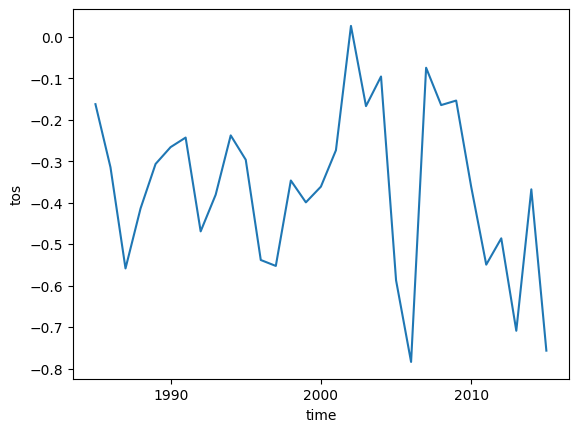

In [8]:
#models['CAMS-CSM1-0']['North Atlantic annual mean climatology'].plot()

In [7]:
models['TaiESM1']['North Atlantic anomaly']

<xarray.DataArray 'tos' (time: 165)> Size: 1kB
array([-0.02437573,  0.04278529,  0.26155336,  0.01156776, -0.10233609,
        0.20908788,  0.28971833,  0.13653486,  0.09338283,  0.39006311,
        0.37686836,  0.28217614,  0.07714503,  0.22194089,  0.35266817,
        0.273838  ,  0.24291337,  0.30696558,  0.26350593,  0.21190931,
        0.23698413,  0.33898844,  0.52248402,  0.52911584,  0.41076912,
        0.50519729,  0.42896488,  0.14750102,  0.10380749,  0.06731033,
        0.09944855,  0.06578471,  0.1261205 ,  0.18761254, -0.01328078,
        0.05267779,  0.13395467, -0.11858942,  0.20662007,  0.07228129,
        0.21472304,  0.10865532, -0.11962633, -0.32895555, -0.25467601,
       -0.06015782, -0.13840142, -0.0831792 , -0.08714505, -0.1318701 ,
       -0.06863232, -0.08047332, -0.15952703, -0.28239559, -0.26010273,
       -0.08979456, -0.12124911, -0.21286747, -0.39889456, -0.2296328 ,
       -0.21925275, -0.35754413, -0.5057368 , -0.49412144, -0.4904193 ,
       -0.31264095, -0.24812746, -0.3497814 , -0.16876344, -0.14306312,
       -0.00934545,  0.01633833, -0.01199632, -0.36950834, -0.12827372,
       -0.19817783, -0.23316709, -0.18011365, -0.10099855, -0.22217304,
       -0.20108072, -0.11658035, -0.15270797,  0.00439644,  0.09983359,
        0.22746602,  0.13427158,  0.09794958,  0.1686951 ,  0.27061561,
        0.25210209,  0.21505468,  0.04719226,  0.15022775,  0.2094292 ,
        0.03684082,  0.10059205,  0.00545005, -0.08686964,  0.08353667,
        0.00187938, -0.13678384, -0.03618305,  0.09249205, -0.00056029,
        0.0189366 , -0.11059396, -0.1203906 , -0.08047304, -0.06358702,
       -0.00407834, -0.23208104, -0.22305587, -0.18118165, -0.42362495,
       -0.41613039, -0.27119643, -0.44568858, -0.49832404, -0.41497429,
       -0.43617225, -0.25468007, -0.20866326, -0.18985621, -0.37077921,
       -0.546663  , -0.38753751, -0.2477405 , -0.3301551 , -0.29205131,
       -0.23367843, -0.27624885, -0.49073137, -0.46265977, -0.19281746,
       -0.21481451, -0.16391435, -0.24381478, -0.34581769, -0.12949682,
       -0.0923681 , -0.17105949, -0.37645926, -0.0725676 , -0.04211581,
       -0.04804813, -0.13475851, -0.27215583, -0.19995452, -0.01146404,
        0.05932886,  0.06974075,  0.12245364,  0.36126405,  0.01528889,
        0.14272194, -0.04706766,  0.20663175,  0.1945414 ,  0.37062754,
        0.25228553,  0.25614918,  0.33261438,  0.21974644,  0.15530023])
Coordinates:
  * time     (time) object 1kB 1850-12-31 00:00:00 ... 2014-12-31 00:00:00

In [9]:
len(models)

40

Nord Atlantico anomalie - Dataset ESA-CCI

Text(0.5, 0.98, 'Anomalia Nord Atlantico ESA rispetto alla media climatologica 1984 - 2014')

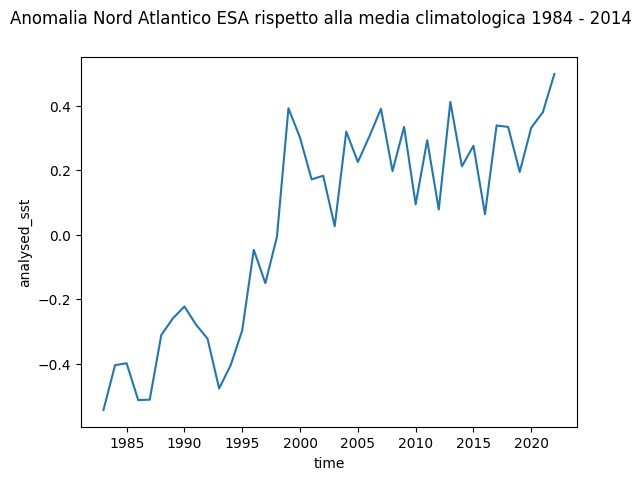

In [10]:
#ESA-CCI box Nord Atlantico
dataset_ESA_na=xr.open_dataset('/work/users/guest/sbeltrami/prova/ESA-CCI_SST_remap.nc').sel(lon=slice(260,360), lat=slice(30,70)) #seleziono lon lat del Nord Atlantico
dataset_ESA_na_celsius = convert_dataset_celsius(dataset_ESA_na["analysed_sst"]) #converto in °C
#dataset pesato
dataset_ESA_weighted_na = compute_dataset_weighted(dataset_ESA_na_celsius)
#media annuale Nord Atlantico
annual_mean_esa_na = compute_annual_mean_weighted(dataset_ESA_weighted_na)
#Scelgo periodo su cui calcolare la climatologia
esa_na_1984_2014 = dataset_ESA_na_celsius.sel(time=slice("1984-01", "2014-12"))
#peso il dataset del periodo scelto
esa_na_1984_2014_weighted = compute_dataset_weighted(esa_na_1984_2014)
#calcolo la media annuale sul periodo scelto
annual_mean_esa_na_30 = compute_annual_mean_weighted(esa_na_1984_2014_weighted)
#Calcolo l'anomalia di tos rispetto al periodo di riferimento scelto
anomaly_esa = compute_anomaly(annual_mean_esa_na,annual_mean_esa_na_30)
#plot
anomaly_esa.plot()
plt.suptitle('Anomalia Nord Atlantico ESA rispetto alla media climatologica 1984 - 2014')

Plot anomalia Nord Atlantico modelli e dataset ESA-CCI

In [11]:
#models['FGOALS-f3-L']['North Atlantic anomaly'].time

In [11]:
anomaly_esa.time

<xarray.DataArray 'time' (time: 40)> Size: 320B
array(['1982-12-31T00:00:00.000000000', '1983-12-31T00:00:00.000000000',
       '1984-12-31T00:00:00.000000000', '1985-12-31T00:00:00.000000000',
       '1986-12-31T00:00:00.000000000', '1987-12-31T00:00:00.000000000',
       '1988-12-31T00:00:00.000000000', '1989-12-31T00:00:00.000000000',
       '1990-12-31T00:00:00.000000000', '1991-12-31T00:00:00.000000000',
       '1992-12-31T00:00:00.000000000', '1993-12-31T00:00:00.000000000',
       '1994-12-31T00:00:00.000000000', '1995-12-31T00:00:00.000000000',
       '1996-12-31T00:00:00.000000000', '1997-12-31T00:00:00.000000000',
       '1998-12-31T00:00:00.000000000', '1999-12-31T00:00:00.000000000',
       '2000-12-31T00:00:00.000000000', '2001-12-31T00:00:00.000000000',
       '2002-12-31T00:00:00.000000000', '2003-12-31T00:00:00.000000000',
       '2004-12-31T00:00:00.000000000', '2005-12-31T00:00:00.000000000',
       '2006-12-31T00:00:00.000000000', '2007-12-31T00:00:00.000000000',
       '2008-12-31T00:00:00.000000000', '2009-12-31T00:00:00.000000000',
       '2010-12-31T00:00:00.000000000', '2011-12-31T00:00:00.000000000',
       '2012-12-31T00:00:00.000000000', '2013-12-31T00:00:00.000000000',
       '2014-12-31T00:00:00.000000000', '2015-12-31T00:00:00.000000000',
       '2016-12-31T00:00:00.000000000', '2017-12-31T00:00:00.000000000',
       '2018-12-31T00:00:00.000000000', '2019-12-31T00:00:00.000000000',
       '2020-12-31T00:00:00.000000000', '2021-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 320B 1982-12-31 1983-12-31 ... 2021-12-31

In [12]:
#Nord Atlantico
#Creo una lista con il nome dei modelli
models_list = list(models.keys())

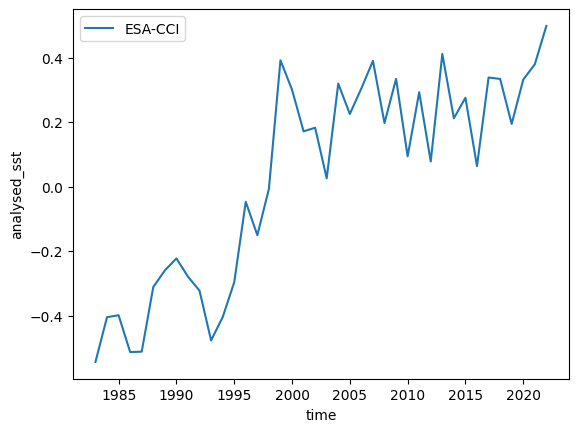

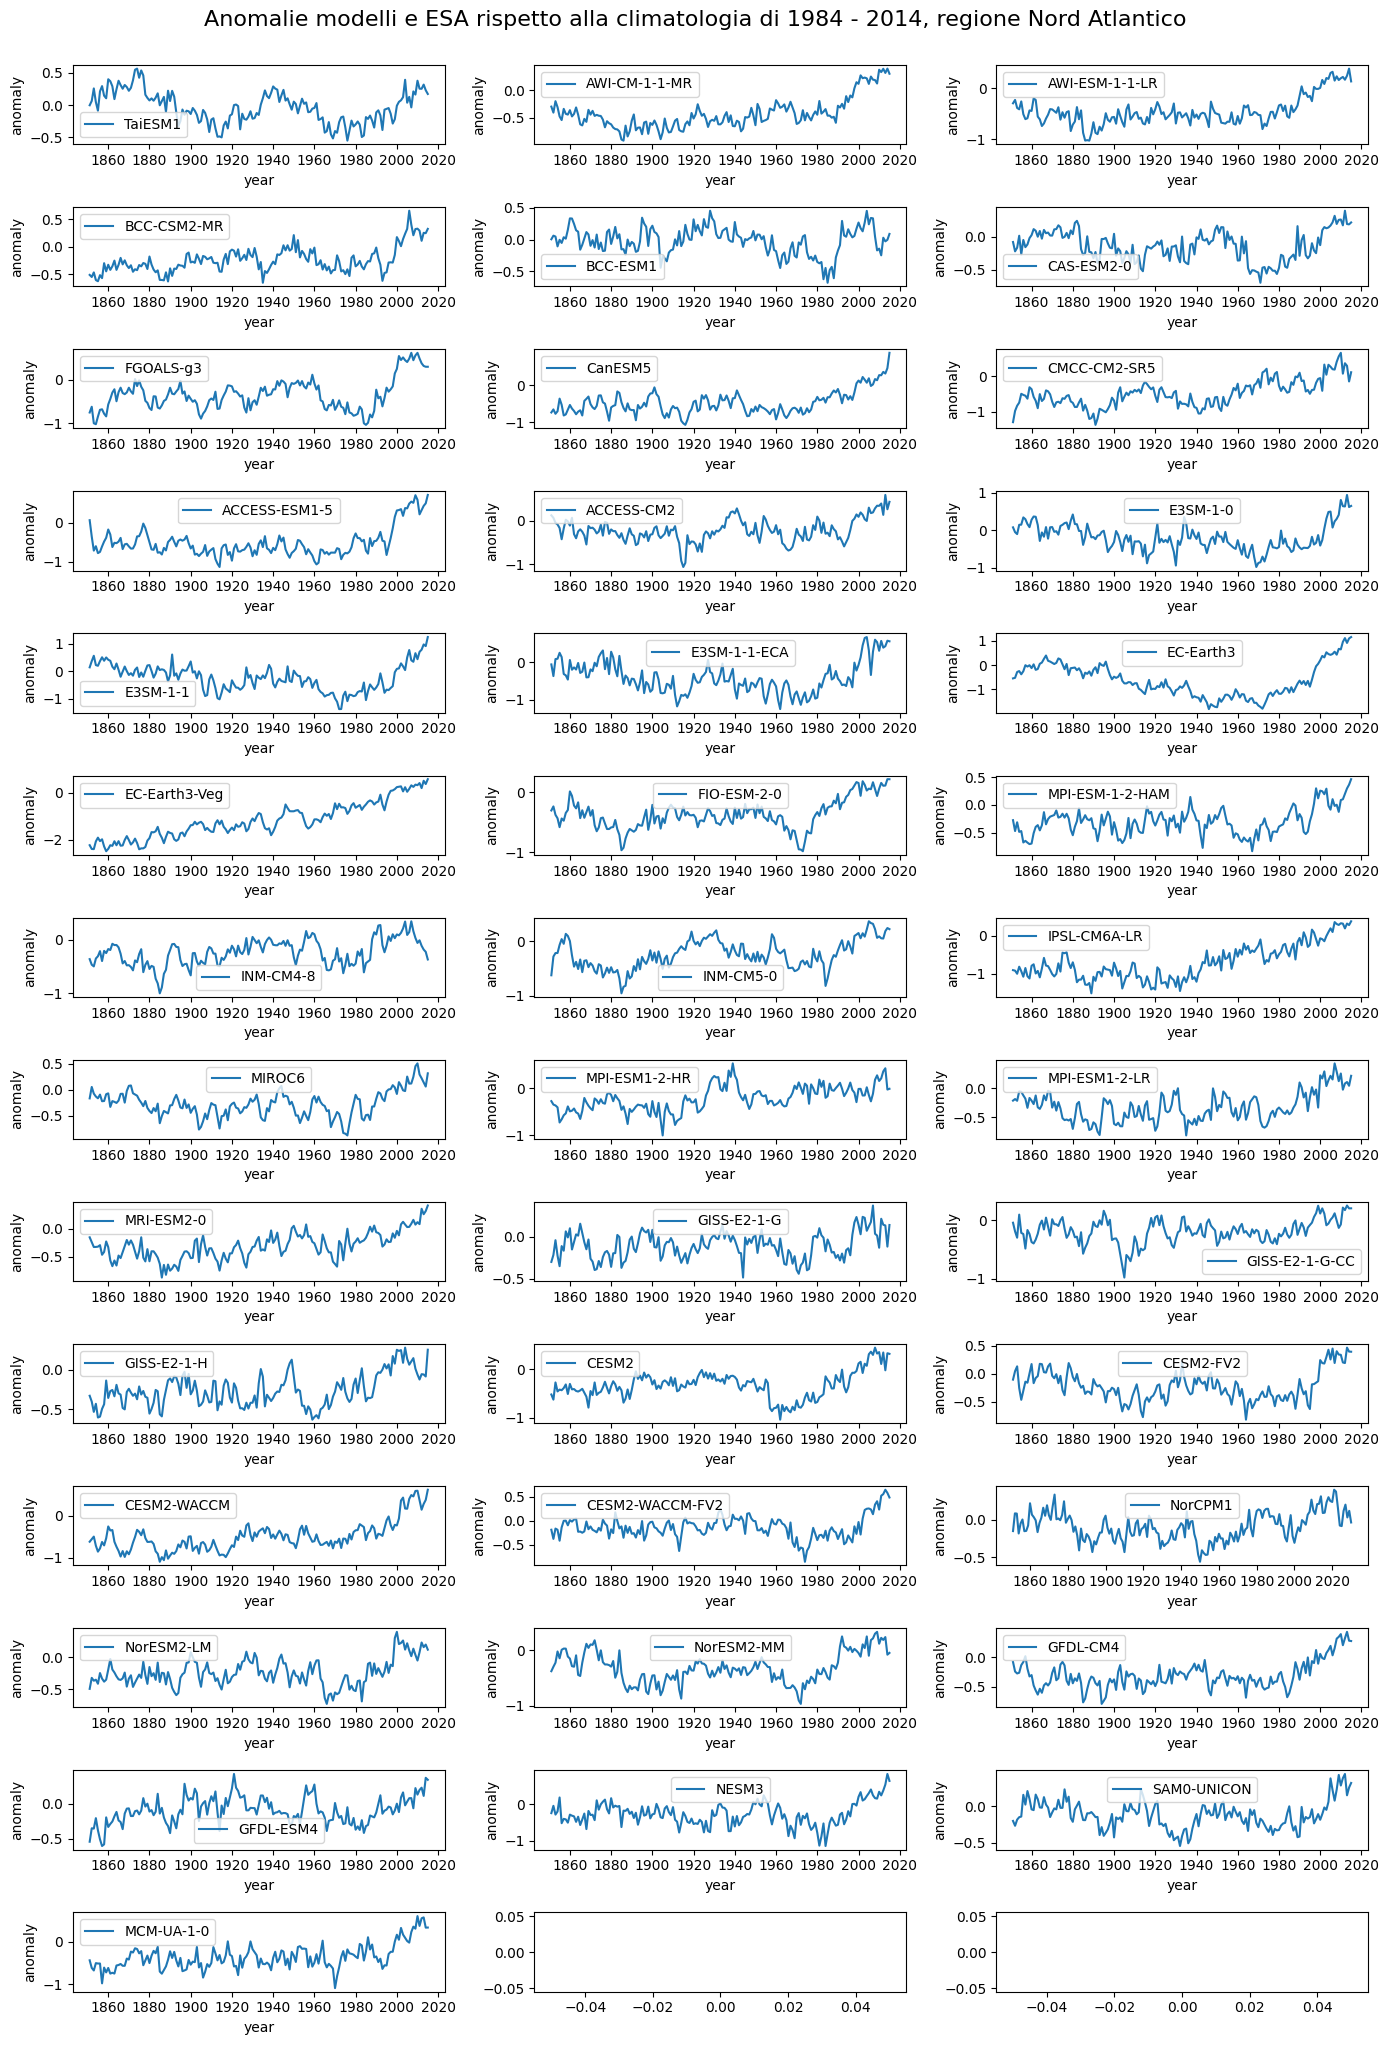

In [16]:
#Plot delle anomalie dei modelli e di ESA su periodo di riferimento 1984-2014
# Plot della anomalia di ESA-CCI
anomaly_esa.plot(label='ESA-CCI')
plt.legend()
#Plot dei modelli
fig, ax = plt.subplots(nrows=14,ncols=3,figsize=(14,20))
# Plot dei modelli
for i in range(14): #ciclo sulle righe
    for j in range(3): #ciclo sulle colonne
        models_index_list = i * 3 + j #indice del modello all'interno della lista
        if models_index_list == len(models_list):
            break
        model_name = models_list[models_index_list]
        data_array = models[model_name]['North Atlantic anomaly'].copy()
        data_array = data_array.assign_coords(time=data_array['time'].values.astype('datetime64[ns]'))
        data_array.plot(ax=ax[i, j], label=model_name)
        ax[i,j].legend()
        ax[i,j].set_ylabel('anomaly')
        ax[i,j].set_xlabel('year')
        
for axes in ax.flat:
    axes.axis("tight")


#plt.legend()
plt.tight_layout()
# Titolo
fig.suptitle('Anomalie modelli e ESA rispetto alla climatologia di 1984 - 2014, regione Nord Atlantico', fontsize=16, y=1.02)

plt.savefig('anomalies.pdf', format='pdf')

Bias : Medie stagionali (modello - osservazioni), con media climatologica delle osservazioni su periodo 1983 - 2014

Dataset ESA-CCI

In [17]:
#Dataset ESA - CCI
#Creo un dizionario in cui vado a mettere la media temporale per ogni stagione MAM, JJA, SON, DJF
esa_na_seas_mean = {}

In [18]:
#Calcolo la media temporale su tutti e 4 i trimestri MAM = 1, JJA = 2, SON = 3, DJF = 4
for i in range(4):
    esa_na_seas_mean[i+1] = compute_mean_resample_mar(dataset_ESA_na_celsius,"1982","2014",i)

In [16]:
esa_na_seas_mean.keys()

dict_keys([1, 2, 3, 4])

Modelli

In [17]:
models['TaiESM1'].keys()

dict_keys(['name', 'path', 'path remap', 'dataset', 'dataset weighted', 'dataset annual mean', 'North Atlantic box', 'North Atlantic dataset weighted', 'North Atlantic annual mean weighted', 'North Atlantic climatology weighted', 'North Atlantic annual mean climatology', 'North Atlantic anomaly'])

In [19]:
#Bias modelli
for name in models:
    #Seleziono il box Nord Atlantico
    na_box = models[name]['North Atlantic box']
    #media temporale delle stagioni MAM, JJA, SON
    for i in range(4): # ciclo su tutte le stagioni
        #Calcolo la media temporale per ogni stagione dei modelli, per un anno --> da aggiungere anni!
        model_na_seas_mean = compute_mean_resample_mar(na_box["tos"],"1982","2014",i)
        #Calcolo il bias modelli - dataset
        if (i+1) == 1: # MAM
            models[name]['North Atlantic bias MAM'] = model_na_seas_mean - esa_na_seas_mean[i+1]
        elif (i+1) == 2 : # JJA
            models[name]['North Atlantic bias JJA'] = model_na_seas_mean - esa_na_seas_mean[i+1]
        elif (i+1) == 3 : #SON
            models[name]['North Atlantic bias SON'] = model_na_seas_mean - esa_na_seas_mean[i+1]
        elif (i+1) == 4 : #DJF
            models[name]['North Atlantic bias DJF'] = model_na_seas_mean - esa_na_seas_mean[i+1]

Modello CAMS-CSM1-0

In [19]:
#creo array 2d per il modello CAMS-CSM1-0
cam = np.zeros((20,50))
cam  = models['CAMS-CSM1-0']['North Atlantic bias MAM'].values

In [20]:
number_nan = 0
for i in range(20):
    for j in range(50):
        if np.isnan(cam[i,j]): #se l'elemento i,j-esimo è un nan
            number_nan = number_nan + 1
number_nan

965

In [21]:
models['CAMS-CSM1-0']['North Atlantic bias MAM']

<xarray.DataArray (lat: 20, lon: 50)> Size: 4kB
array([[        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan],
...
                nan,         nan,         nan,         nan,         nan,
         0.2263341 ,  0.21642482,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,  0.05857491,         nan, -0.37476826,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,  0.05172169,
                nan,         nan, -2.2593052 , -3.8071885 ,         nan,
        -4.272504  , -3.793542  ,         nan, -3.116127  , -2.671623  ,
        -2.3260403 , -2.5649211 , -4.422303  , -4.7977824 , -4.8110266 ],
       [ 0.5557643 ,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,  0.22713625,         nan,         nan,         nan,
                nan,         nan,  0.16079843,  0.16404891,         nan,
                nan,         nan,         nan, -0.05342913,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan, -0.1180768 ,
                nan, -1.0647888 , -1.2378052 ,         nan,         nan,
        -2.2158108 ,         nan, -5.05742   ,         nan, -6.138921  ]],
      dtype=float32)
Coordinates:
  * lon      (lon) float64 400B 260.0 262.0 264.0 266.0 ... 354.0 356.0 358.0
  * lat      (lat) float64 160B 31.0 33.0 35.0 37.0 39.0 ... 63.0 65.0 67.0 69.0

Creo la feature matrix con dimensioni = (42,20x40)

In [20]:
n_rows = len(models['ACCESS-CM2']['North Atlantic bias MAM'].lat.values) # prendo un modello generico e calcolo il numero di righe, pari al numero di grid cell sulla latitudine
n_cols = len(models['ACCESS-CM2']['North Atlantic bias MAM'].lon.values) #il numero di colonne è pari al numero di grid cell sulla longitudine
n_elements = n_rows * n_cols
n_models = len(models) # numero di modelli

In [21]:
np_array_models_2d = np.zeros((n_rows,n_cols)) #inizializzazione array 2-dim, che ha sulle colonne la longitudine e sulle righe la latitudine e andrò a mettere i valori dei bias di temperatura della stagione MAM
np_array_models_1d = np.zeros(n_elements) #inizializzazione array 1-dim, creato con righe di np_array_models_2d messe una accanto all'altra
feature_matrix_init = np.zeros((n_models,n_elements)) #inizializzazione matrice con righe pari al numero di modelli e per ogni riga vado a mettere 
i = 0 #inizializzazione indice righe feature_matrix_init
feature_matrix_init.shape

(40, 800)

In [22]:
for name in models.keys(): #models_list è una lista contenente il nome di tutti i modelli che sto utilizzando. Quindi ciclo sul numero dei modelli
    #Creo array
    np_array_models_2d = models[name]['North Atlantic bias MAM'].values #estraggo i valori da bias MAM e li metto in un array 2d, dove sulle righe c'è la latitudine e sulle colonne la longitudine
    np_array_models_1d = np_array_models_2d.flatten() #array 1d con numero di elementi pari a lat x lon (messe una accanto all'altra le righe dell'array 2d precedente)
    #Creo feature matrix
    feature_matrix_init[i,:] = np_array_models_1d #ogni riga di feature_matrix_init è pari a np_array_models_1d
    i = i + 1 #aggiorno indice i

feature_matrix_init.shape

(40, 800)

Elimino le colonne contenenti 'nan'

In [23]:
#Conto il numero di colonne, della matrice feature matrix, che hanno almeno un elemento nan
number_nan = 0
for j in range(n_elements): #ciclo sulle colonne di feature_matrix_init
    for i in range(n_models): #ciclo sulle righe di feature_matrix_init
        if np.isnan(feature_matrix_init[i,j]): #se l'elemento i,j-esimo è un nan
            number_nan = number_nan + 1 #aggiorno il numero di colonne che hanno almeno un elemento nan
            break # rinizio con il ciclo su j

number_nan

309

In [24]:
#Creo un array contenente il numero della j-esima colonna che ha almeno un elemento nan        
number_nan
array_coloumn_nan = np.zeros(number_nan, dtype=int) #inizializzo l'array in cui andrò a mettere il numero della j-esima colonna che ha almeno un elmento nan
k = 0 # indice per gli elementi di array_coloumn_nan
for j in range(n_elements): #ciclo sulle colonne di feature_matrix_init
    for i in range(n_models): #ciclo sulle righe di feature_matrix_init
        if np.isnan(feature_matrix_init[i,j]): #se l'elemento i,j-esimo è un nan
            array_coloumn_nan[k] = j 
            k = k + 1 #aggiorno l'indice di array_coloumn_nan
#            feature_matrix_init = np.delete(feature_matrix_init,j,axis=1) #elimino la j-esima colonna
#           j = j - 1 #perché ho ridotto il numero di colonne di uno
            break # rinizio con il ciclo su j
#    if j == (number_nan):
#        break

In [25]:
k = 0  # Inizializzo indice array_coloumn_nan

while k < number_nan:  # Ciclo sugli elementi dell'array_coloumn_nan
    col_index_to_remove = array_coloumn_nan[k]
    feature_matrix_init = np.delete(feature_matrix_init, col_index_to_remove, axis=1)
    
    # Aggiorno gli indici successivi nell'array_coloumn_nan
    array_coloumn_nan = np.array([k - 1 if k > col_index_to_remove else k for k in array_coloumn_nan])
    
    k = k + 1  # Aggiorno indice k

#fatto da me
#k = 0 #inizializzo indice array_coloumn_nan

#while k <= number_nan: #ciclo sugli elementi dell'array_coloumn_nan
#    col_remove = array_coloumn_nan[k] # colonna da rimuovere
#    feature_matrix_init = np.delete(feature_matrix_init,array_coloumn_nan[k],axis=1) #elimino la j-esima colonna
#    if k == (number_nan - 1):
#        break
#    else:
#        array_coloumn_nan[(k+1):] = array_coloumn_nan - 1
#    k = k + 1 #aggiorno indice k

In [26]:
feature_matrix_init.shape

(40, 491)

K-Means clustering

In [27]:
import sklearn
from sklearn.cluster import KMeans

In [28]:
k_means = KMeans(n_clusters=4, random_state=0) #random_state=0 in modo t.c. la scelta dei centroid casuale all'iniio sia riproducibile
k_means.fit(feature_matrix_init)

#Etichetta cluster per ogni modello
labels = k_means.labels_

#Centroid per ogni cluster
centroids = k_means.cluster_centers_

#quale cluster è assegnato ad ogni modello
i = 0 # indice labels array
for name in models.keys():
    print("Il modello", models[name]['name'],"è assegnato al cluster numero:", labels[i])        
    i = i + 1 #aggiorno indice labels array
print("Centroid dei cluster:", centroids)

Il modello TaiESM1 è assegnato al cluster numero: 0
Il modello AWI-CM-1-1-MR è assegnato al cluster numero: 0
Il modello AWI-ESM-1-1-LR è assegnato al cluster numero: 0
Il modello BCC-CSM2-MR è assegnato al cluster numero: 2
Il modello BCC-ESM1 è assegnato al cluster numero: 2
Il modello CAS-ESM2-0 è assegnato al cluster numero: 0
Il modello FGOALS-g3 è assegnato al cluster numero: 2
Il modello CanESM5 è assegnato al cluster numero: 1
Il modello CMCC-CM2-SR5 è assegnato al cluster numero: 0
Il modello ACCESS-ESM1-5 è assegnato al cluster numero: 0
Il modello ACCESS-CM2 è assegnato al cluster numero: 0
Il modello E3SM-1-0 è assegnato al cluster numero: 3
Il modello E3SM-1-1 è assegnato al cluster numero: 3
Il modello E3SM-1-1-ECA è assegnato al cluster numero: 3
Il modello EC-Earth3 è assegnato al cluster numero: 1
Il modello EC-Earth3-Veg è assegnato al cluster numero: 0
Il modello FIO-ESM-2-0 è assegnato al cluster numero: 0
Il modello MPI-ESM-1-2-HAM è assegnato al cluster numero: 0


Conto quanti modelli ci sono per ogni cluster e creo 4 liste con i nomi dei modelli in ogni cluster

In [30]:
#Inizializzo l'indice per l'i-esimo cluster
cluster_0 = 0
cluster_1 = 0
cluster_2 = 0
cluster_3 = 0
#Inizializzo le liste in cui andrò a mettere il nome dei modelli per ogni cluster
list_cluster_0 = []
list_cluster_1 = []
list_cluster_2 = []
list_cluster_3 = []

#conto quanti modelli ci sono per ogni cluster
for i in range(len(models)):
    if labels[i] == 0:
        cluster_0 = cluster_0 + 1 #aggiorno il numero di elementi all'interno del cluster 0
        list_cluster_0.append(models_list[i]) #aggiungo un nome alla volta: cioè l'elemento j-esimo della lista dei nomi del cluster 0 è pari all'elemento i-esimo della lista dei nomi di tutti i modelli
    elif labels[i] == 1:
        cluster_1 = cluster_1 + 1
        list_cluster_1.append(models_list[i])
        #print(i,cluster_1)
    elif labels[i] == 2:
        cluster_2 = cluster_2 + 1
        list_cluster_2.append(models_list[i])
    elif labels[i] == 3:
        cluster_3 = cluster_3 + 1
        list_cluster_3.append(models_list[i])

print(cluster_0,cluster_1,cluster_2,cluster_3)
print(sum([cluster_0,cluster_1,cluster_2,cluster_3]))
print(list_cluster_0)
print(list_cluster_1)
print(list_cluster_2)
print(list_cluster_3)

22 4 10 4
40
['TaiESM1', 'AWI-CM-1-1-MR', 'AWI-ESM-1-1-LR', 'CAS-ESM2-0', 'CMCC-CM2-SR5', 'ACCESS-ESM1-5', 'ACCESS-CM2', 'EC-Earth3-Veg', 'FIO-ESM-2-0', 'MPI-ESM-1-2-HAM', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'NorESM2-LM', 'NorESM2-MM', 'GFDL-ESM4', 'SAM0-UNICON']
['CanESM5', 'EC-Earth3', 'IPSL-CM6A-LR', 'MCM-UA-1-0']
['BCC-CSM2-MR', 'BCC-ESM1', 'FGOALS-g3', 'INM-CM4-8', 'INM-CM5-0', 'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'GISS-E2-1-H', 'NorCPM1', 'GFDL-CM4']
['E3SM-1-0', 'E3SM-1-1', 'E3SM-1-1-ECA', 'NESM3']


Plot dei bias in base al cluster

Cluster 0

/tmp/ipykernel_533780/4085193249.py:12: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax[i,j].legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is

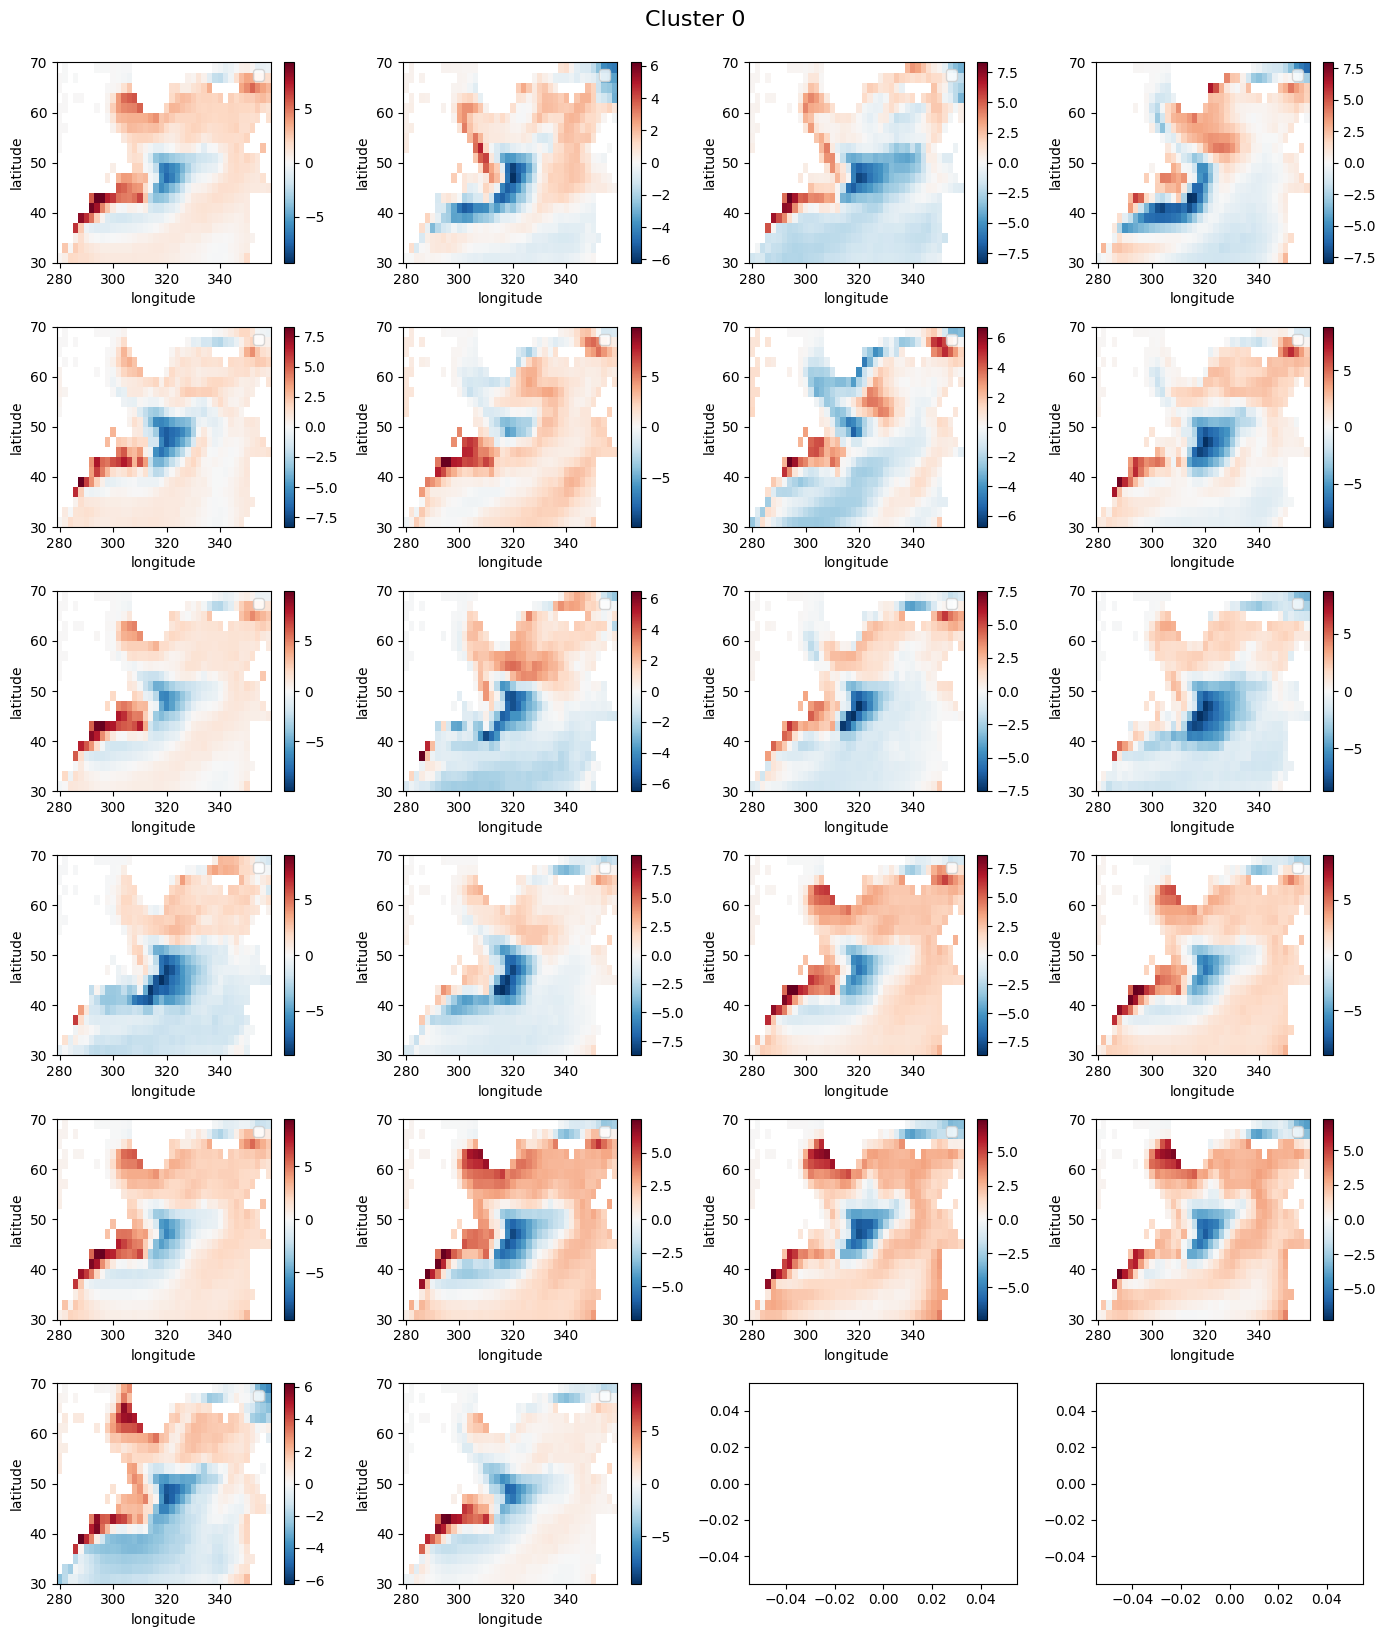

In [31]:
#Plot dei modelli
fig, ax = plt.subplots(nrows=6,ncols=4,figsize=(14,16))
# Plot dei modelli
for i in range(6): #ciclo sulle righe 
    for j in range(4): #ciclo sulle colonne 
        models_index_list = i*4 + j #indice del modello all'interno della lista
        if models_index_list == 22:
            break
        model_name = list_cluster_0[models_index_list]
        data_array = models[model_name]['North Atlantic bias MAM']#.copy()
        data_array.plot(ax=ax[i, j], label=model_name)
        ax[i,j].legend()   
        ax[i,j].set_ylabel('latitude')
        ax[i,j].set_xlabel('longitude')

for axes in ax.flat:
    axes.axis("tight")


#plt.legend()
plt.tight_layout()

# Titolo
fig.suptitle('Cluster 0', fontsize=16, y=1.02)
plt.savefig('cluster_0.pdf', format='pdf')

Cluster 1

/tmp/ipykernel_533780/3931613497.py:10: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax[i,j].legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


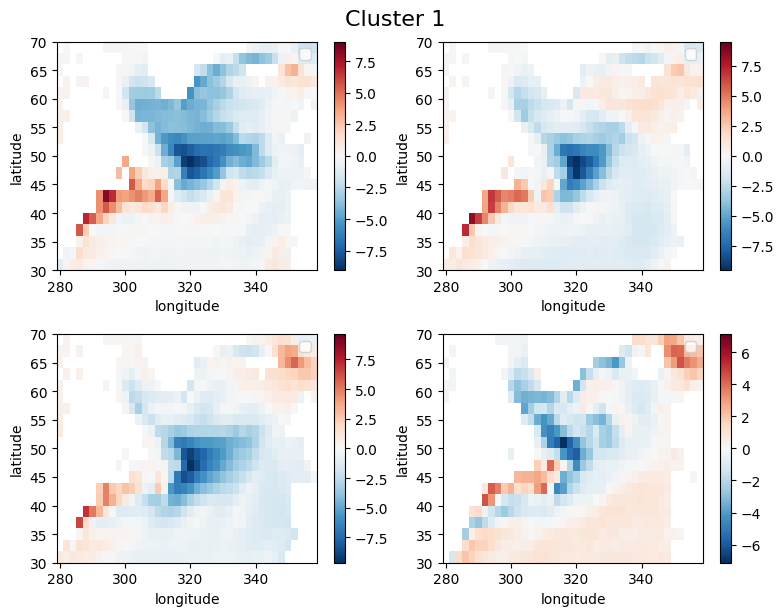

In [34]:
#Plot dei modelli
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(8,6))
# Plot dei modelli
for i in range(2): #ciclo sulle righe 
    for j in range(2): #ciclo sulle colonne 
        models_index_list = i*2 + j #indice del modello all'interno della lista
        model_name = list_cluster_1[models_index_list]
        data_array = models[model_name]['North Atlantic bias MAM']#.copy()
        data_array.plot(ax=ax[i, j], label=model_name)
        ax[i,j].legend()   
        ax[i,j].set_ylabel('latitude')
        ax[i,j].set_xlabel('longitude')

for axes in ax.flat:
    axes.axis("tight")


#plt.legend()
plt.tight_layout()

# Titolo
fig.suptitle('Cluster 1', fontsize=16, y=1.02)
plt.savefig('cluster_1.pdf', format='pdf')

Cluster 2

/tmp/ipykernel_533780/634546220.py:10: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax[i,j].legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is 

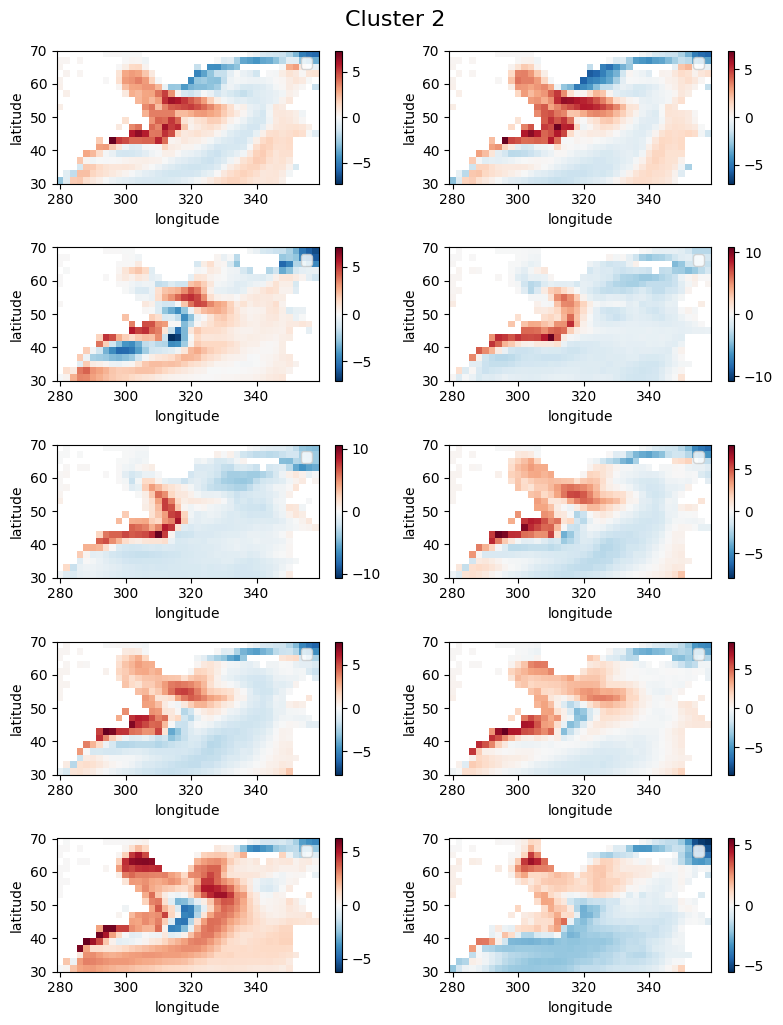

In [ ]:
#Plot dei modelli
fig, ax = plt.subplots(nrows=5,ncols=2,figsize=(6,10))
# Plot dei modelli
for i in range(5): #ciclo sulle righe 
    for j in range(2): #ciclo sulle colonne 
        models_index_list = i*2 + j #indice del modello all'interno della lista
        model_name = list_cluster_2[models_index_list]
        data_array = models[model_name]['North Atlantic bias MAM']#.copy()
        data_array.plot(ax=ax[i, j], label=model_name)
        ax[i,j].legend()   
        ax[i,j].set_ylabel('latitude')
        ax[i,j].set_xlabel('longitude')

for axes in ax.flat:
    axes.axis("tight")


#plt.legend()
plt.tight_layout()

# Titolo
fig.suptitle('Cluster 2', fontsize=16, y=1.02)
plt.savefig('cluster_2.pdf', format='pdf')

Cluster 3

/tmp/ipykernel_533780/1987024265.py:10: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax[i,j].legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


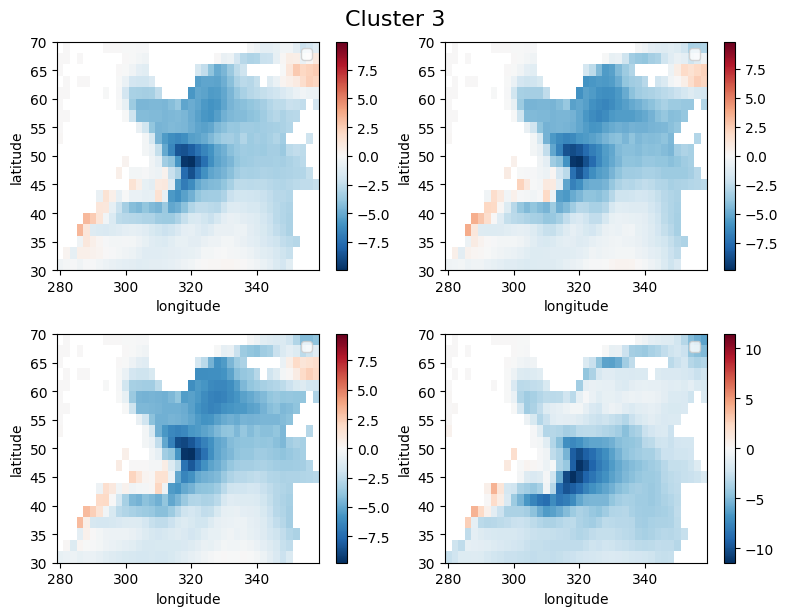

In [38]:
#Plot dei modelli
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(8,6))
# Plot dei modelli
for i in range(2): #ciclo sulle righe 
    for j in range(2): #ciclo sulle colonne 
        models_index_list = i*2 + j #indice del modello all'interno della lista
        model_name = list_cluster_3[models_index_list]
        data_array = models[model_name]['North Atlantic bias MAM']#.copy()
        data_array.plot(ax=ax[i, j], label=model_name)
        ax[i,j].legend()   
        ax[i,j].set_ylabel('latitude')
        ax[i,j].set_xlabel('longitude')

for axes in ax.flat:
    axes.axis("tight")


#plt.legend()
plt.tight_layout()

# Titolo
fig.suptitle('Cluster 3', fontsize=16, y=1.02)
plt.savefig('cluster_3.pdf', format='pdf')

Plot dei bias per ogni stagione

MAM

/tmp/ipykernel_533780/3836943220.py:13: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax[i,j].legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is

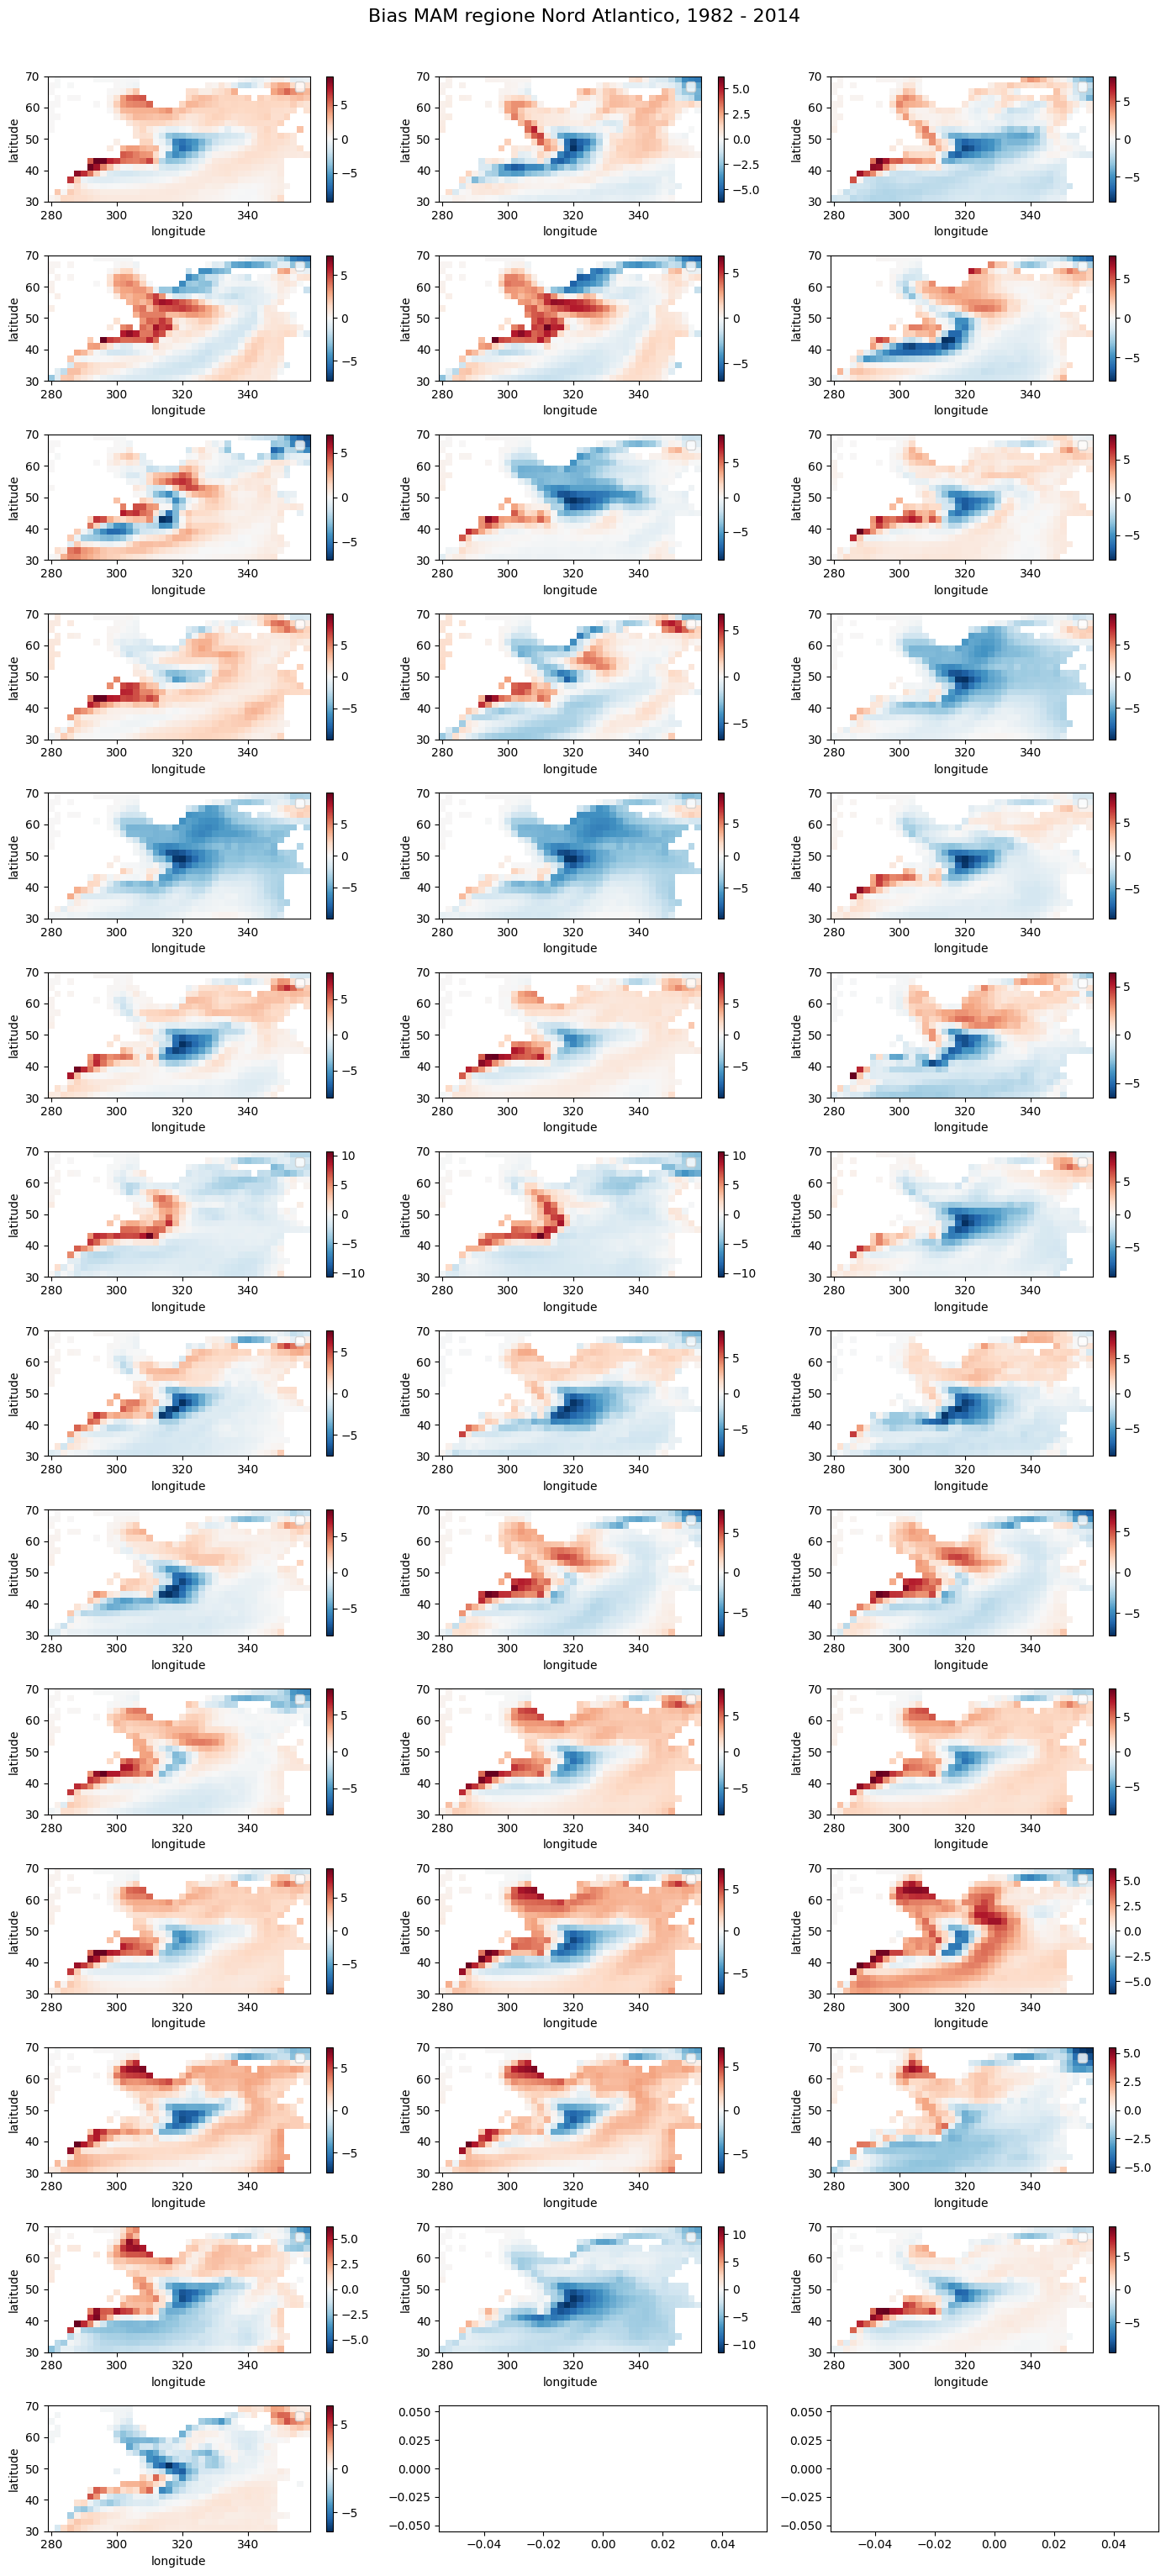

In [40]:
#MAM
#Plot dei modelli
fig, ax = plt.subplots(nrows=14,ncols=3,figsize=(14,30))
# Plot dei modelli
for i in range(14): #ciclo sulle righe 7
    for j in range(3): #ciclo sulle colonne 6
        models_index_list = i*3 + j #indice del modello all'interno della lista
        if models_index_list == len(models_list):
            break
        model_name = models_list[models_index_list]
        data_array = models[model_name]['North Atlantic bias MAM']#.copy()
        data_array.plot(ax=ax[i, j], label=model_name)
        ax[i,j].legend()   
        ax[i,j].set_ylabel('latitude')
        ax[i,j].set_xlabel('longitude')

for axes in ax.flat:
    axes.axis("tight")


#plt.legend()
plt.tight_layout()

# Titolo
fig.suptitle('Bias MAM regione Nord Atlantico, 1982 - 2014', fontsize=16, y=1.02)
plt.savefig('bias_MAM.pdf', format='pdf')

JJA

/tmp/ipykernel_1269/3392657668.py:11: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax[i,j].legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is c

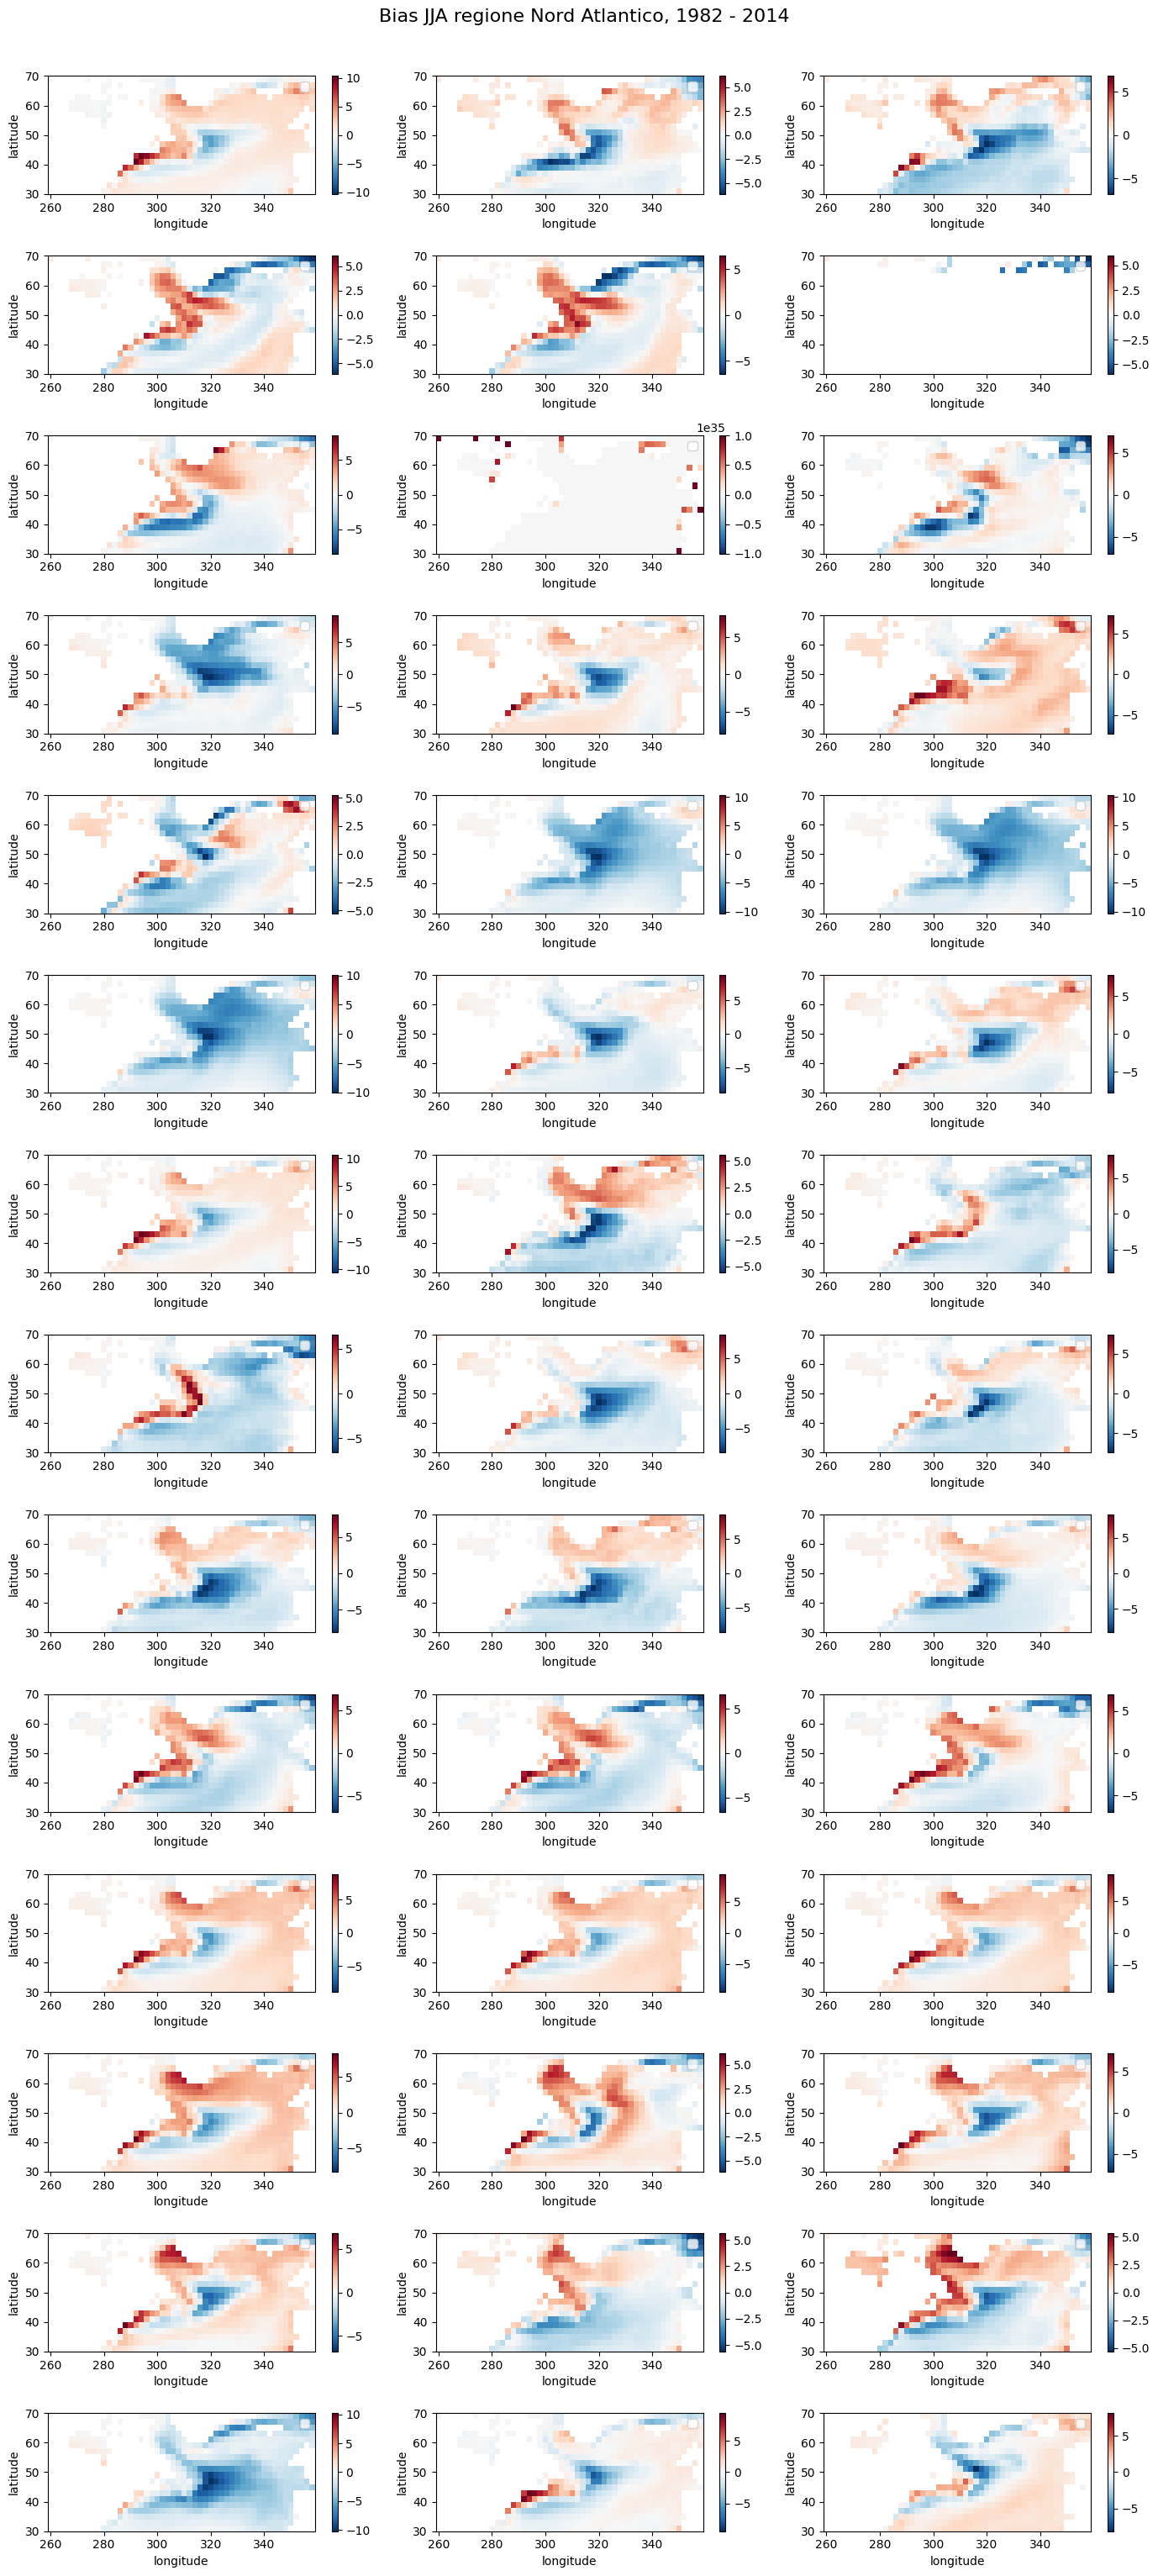

In [52]:
#JJA
#Plot dei modelli
fig, ax = plt.subplots(nrows=14,ncols=3,figsize=(14,30))
# Plot dei modelli
for i in range(14): #ciclo sulle righe 7
    for j in range(3): #ciclo sulle colonne 6
        models_index_list = i*3 + j #indice del modello all'interno della lista
        if models_index_list == len(models_list):
            break
        model_name = models_list[models_index_list]
        data_array = models[model_name]['North Atlantic bias JJA']#.copy()
        data_array.plot(ax=ax[i, j], label=model_name)
        ax[i,j].legend()   
        ax[i,j].set_ylabel('latitude')
        ax[i,j].set_xlabel('longitude')

for axes in ax.flat:
    axes.axis("tight")


#plt.legend()
plt.tight_layout()

# Titolo
fig.suptitle('Bias JJA regione Nord Atlantico, 1982 - 2014', fontsize=16, y=1.02)
plt.savefig('bias_JJA.pdf', format='pdf')

SON

/tmp/ipykernel_1269/2039816427.py:11: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax[i,j].legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is c

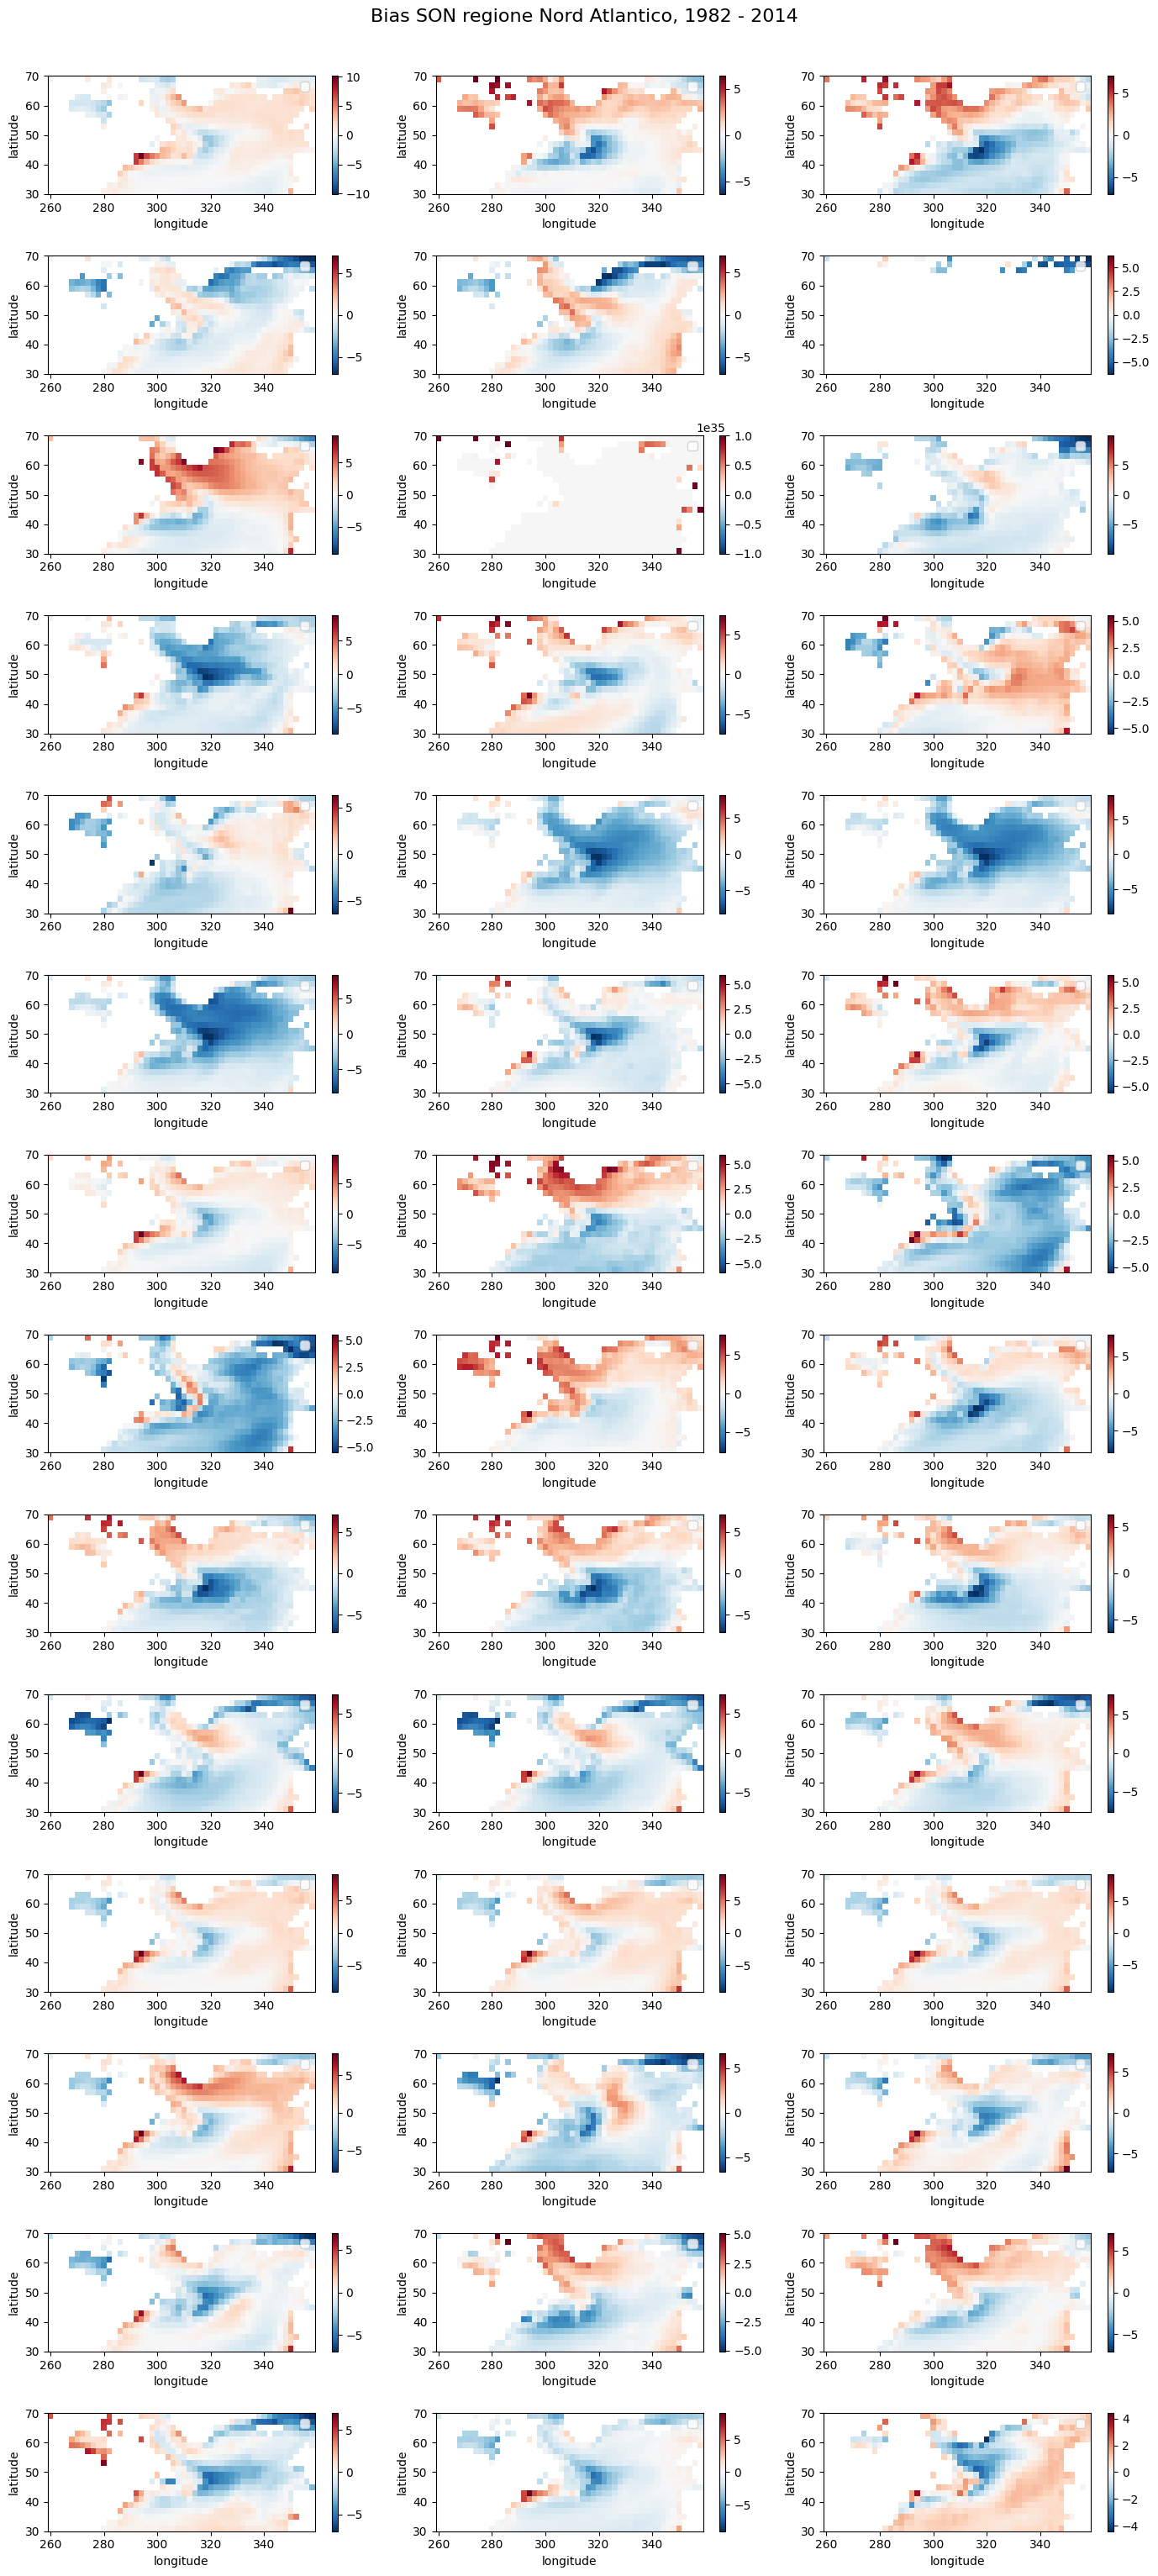

In [53]:
#SON
#Plot dei modelli
fig, ax = plt.subplots(nrows=14,ncols=3,figsize=(14,30))
# Plot dei modelli
for i in range(14): #ciclo sulle righe 7
    for j in range(3): #ciclo sulle colonne 6
        models_index_list = i*3 + j #indice del modello all'interno della lista
        if models_index_list == len(models_list):
            break
        model_name = models_list[models_index_list]
        data_array = models[model_name]['North Atlantic bias SON']#.copy()
        data_array.plot(ax=ax[i, j], label=model_name)
        ax[i,j].legend()   
        ax[i,j].set_ylabel('latitude')
        ax[i,j].set_xlabel('longitude')

for axes in ax.flat:
    axes.axis("tight")


#plt.legend()
plt.tight_layout()

# Titolo
fig.suptitle('Bias SON regione Nord Atlantico, 1982 - 2014', fontsize=16, y=1.02)
plt.savefig('bias_SON.pdf', format='pdf')

DJF

/tmp/ipykernel_1269/3842991416.py:11: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax[i,j].legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is c

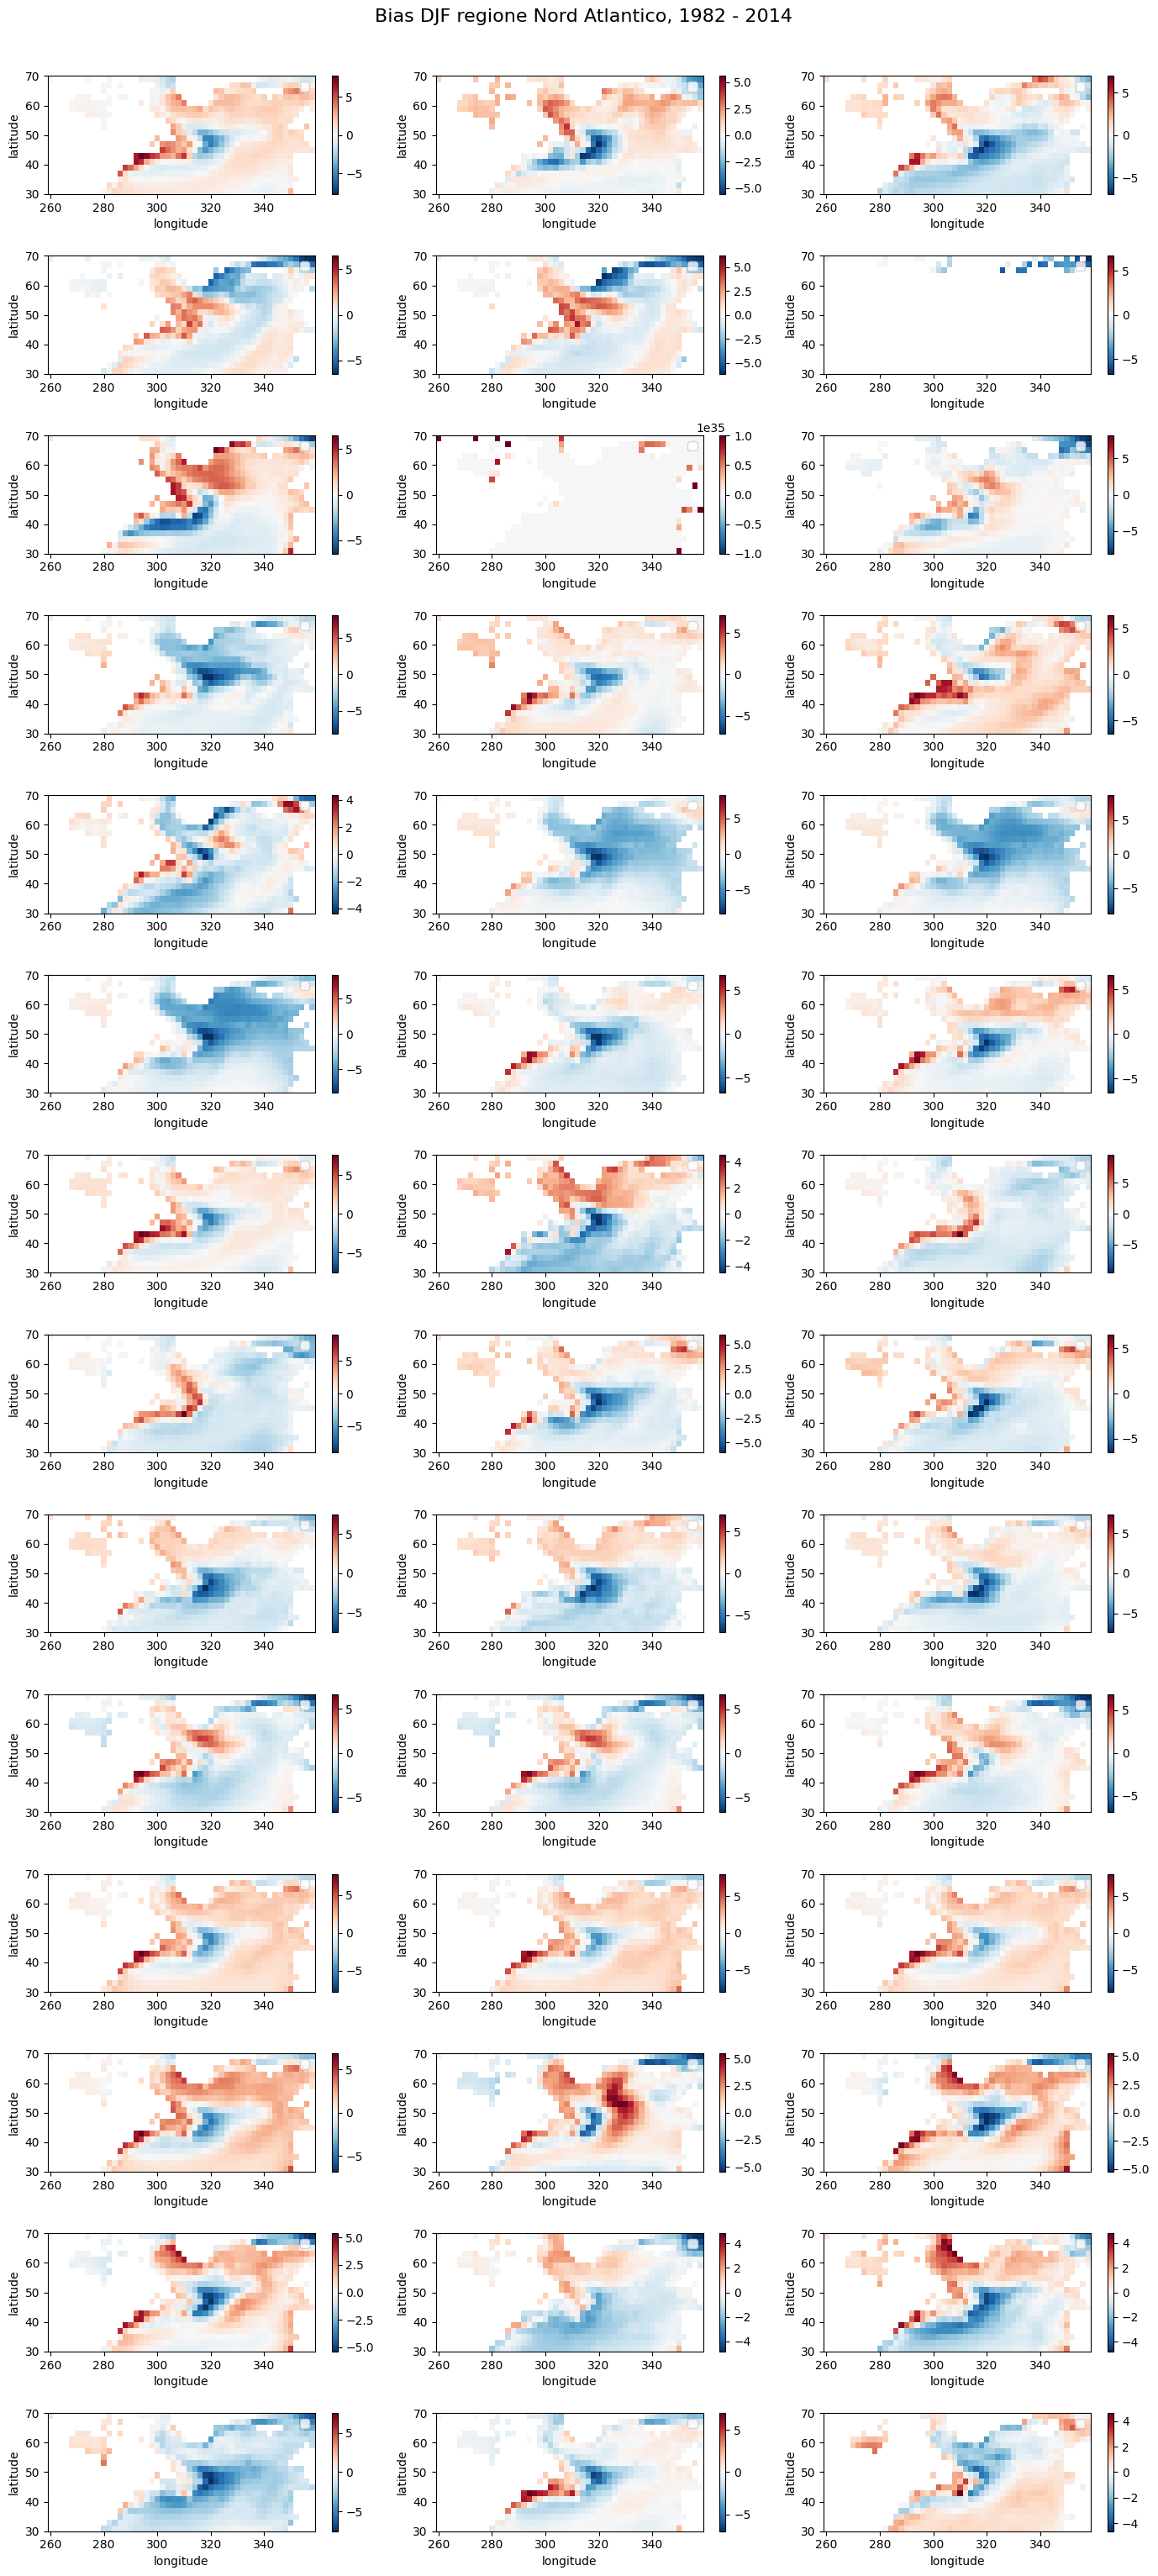

In [54]:
#DJF
#Plot dei modelli
fig, ax = plt.subplots(nrows=14,ncols=3,figsize=(14,30))
# Plot dei modelli
for i in range(14): #ciclo sulle righe 7
    for j in range(3): #ciclo sulle colonne 6
        models_index_list = i*3 + j #indice del modello all'interno della lista
        if models_index_list == len(models_list):
            break
        model_name = models_list[models_index_list]
        data_array = models[model_name]['North Atlantic bias DJF']#.copy()
        data_array.plot(ax=ax[i, j], label=model_name)
        ax[i,j].legend()   
        ax[i,j].set_ylabel('latitude')
        ax[i,j].set_xlabel('longitude')

for axes in ax.flat:
    axes.axis("tight")


#plt.legend()
plt.tight_layout()

# Titolo
fig.suptitle('Bias DJF regione Nord Atlantico, 1982 - 2014', fontsize=16, y=1.02)
plt.savefig('bias_DJF.pdf', format='pdf')

prova con soli 3 modelli

In [ ]:
models = { 'Ec-Earth3':
                    {'path': '/work/users/guest/sbeltrami/tostest.nc',
                     },
            'IPSL-CM6A-LR':
                    {'path': '/work/users/guest/sbeltrami/tostest_ipsl.nc',
                     },
            'MPI-ESM1-2-HR':
                    {'path': '/work/users/guest/sbeltrami/tostest_mpi.nc',
                     }
         }

In [ ]:
for name in models.keys():
    #apertura modelli
    dataset = xr.open_dataset(models[name]['path'])
    #peso il dataset
    models[name]['dataset weighted'] = compute_dataset_weighted(dataset["tos"])
    #medie annuali con dataset pesato
    models[name]['annual mean'] = compute_annual_mean_weighted(models[name]['dataset weighted'])


FileNotFoundError: [Errno 2] No such file or directory: '/work/users/guest/sbeltrami/tostest.nc'

In [ ]:
models['Ec-Earth3'].keys()

dict_keys(['path', 'dataset weighted', 'annual mean'])

In [ ]:
models['Ec-Earth3'].items()

Prova bias metodo + lungo

In [ ]:
dataset_ESA_na_celsius_period = dataset_ESA_na_celsius.sel(time=slice("1983-12","2014-11"))
#dizionario in cui metto la media temporale delle stagioni per il dataset esa
esa_na_seas_mean = {}
#Dataset ESA-CCI: calcolo della media temporale per le stagioni MAM, JJA, SON
for seas in ['MAM','JJA','SON']:
    esa_na_seas_mean[seas] = compute_mean_time_season(dataset_ESA_na_celsius_period,seas)
#Dataset ESA-CCI: seleziona dicembre dell'anno precedente e gennaio/ febbraio dell'anno successivo e calcolo la media sul tempo
esa_na_seas_mean['DJF'] = create_djf_dataset(dataset_ESA_na_celsius_period,1983).mean(dim='time')
#esa_na_seas_mean['MAM'].keys()
type(esa_na_seas_mean)
esa_na_seas_mean['DJF']

In [ ]:
#Bias modelli
for name in models:
    #Seleziono l'anno su cui voglio calcolare il bias di tos
    dataset = xr.open_dataset(models[name]['path remap'])
    #Seleziono il box del Nord Atlantico
    na_box = dataset.sel(lon=slice(260,360), lat=slice(30,70))
    period = na_box["tos"].sel(time=slice("1983-12","1984-11"))
    if name == 'CIESM':
        print("Errore da risolvere con CIESM")
    else:
        #media temporale delle stagioni MAM, JJA, SON
        for seas in ['MAM','JJA','SON']:
            model_na_seas_mean = compute_mean_time_season(period,seas)
            if seas == 'MAM':
                models[name]['Nord Atlantic bias MAM'] = model_na_seas_mean - esa_na_seas_mean[seas]
            elif seas == 'JJA':
                models[name]['Nord Atlantic bias JJA'] = model_na_seas_mean - esa_na_seas_mean[seas]
            elif seas == 'SON':
                models[name]['Nord Atlantic bias SON'] = model_na_seas_mean - esa_na_seas_mean[seas]
        #media temporale per DJF
        model_na_djf_mean = create_djf_dataset(period,1983).mean(dim='time')
        models[name]['Nord Atlantic bias DJF'] = model_na_djf_mean - esa_na_seas_mean['DJF']

